Make model

In [1]:
import torch
import numpy as np
from torch import nn

from src.algo.language.lm import GRUEncoder, OneHotEncoder
from src.algo.nn_modules.mlp import MLPNetwork
    

class LanguageEncoder(nn.Module):

    """ 
    Class to manage and train the language modules: the Language Encoder, the 
    Observation Encoder and the Decoder. 
    """

    def __init__(self, input_dim, context_dim, hidden_dim, embed_dim, policy_layer_N, 
                 lr, vocab, max_message_len, device="cuda:0"):
        super(LanguageEncoder, self).__init__()
        self.device = device

        self.word_encoder = OneHotEncoder(vocab, max_message_len)

        self.lang_encoder = GRUEncoder(
            context_dim, 
            hidden_dim, 
            embed_dim, 
            self.word_encoder,
            device=device)

        self.obs_encoder = MLPNetwork(
            input_dim, context_dim, hidden_dim, policy_layer_N)

        self.clip_loss = nn.CrossEntropyLoss()
        # self.captioning_loss = nn.NLLLoss()

        self.optim = torch.optim.Adam( 
            self.parameters(),
            # list(self.lang_encoder.parameters()) +
            # list(self.obs_encoder.parameters()) +
            # list(self.decoder.parameters()),
            lr=lr)

    def prep_rollout(self, device):
        self.device = device
        self.eval()
        self.to(self.device)
        self.lang_encoder.device = self.device

    def prep_training(self, device):
        self.device = device
        self.train()
        self.to(self.device)
        self.lang_encoder.device = self.device

    def encode_sentences(self, sentence_batch):
        """ 
        Encode a batch of sentences. 
        :param sentence_batch (list(list(int))): Batch of enoded sentences.

        :return context_batch (torch.Tensor): Batch of context vectors, 
            dim=(batch_size, context_dim).
        """
        context_batch = self.lang_encoder(sentence_batch).squeeze(0)
        return context_batch

    def get_save_dict(self):
        save_dict = {
            "lang_encoder": self.lang_encoder.state_dict(),
            "obs_encoder": self.obs_encoder.state_dict()}
        return save_dict

    def load_params(self, save_dict):
        self.lang_encoder.load_state_dict(save_dict["lang_encoder"])
        self.obs_encoder.load_state_dict(save_dict["obs_encoder"])

In [4]:
obs_dim = 77
context_dim = 2
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "Center", "North", "South", "East", "West",
                        "Gem", "Yellow", "Green", "Purple"]
max_mess_len = 6

ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

Transform sentences to ids

In [2]:
import pandas as pd
import random
import json

def load_n_prep_data(path, ll):
    df = pd.read_csv(path, index_col=0)
    df = df.fillna('')

    # Drop majority of rows with empty message
    empty_ids = df.index[df["lang"] == ''].tolist()
    drop_ids = random.sample(empty_ids, len(empty_ids) - 10000)
    df = df.drop(drop_ids)

    # Prepare data
    df["lang"] = df["lang"].apply(lambda x: x.split(" "))
    df["obs"] = df["obs"].apply(json.loads)

    # Encode words to token ids
    df["lang"] = ll.word_encoder.encode_batch(list(df["lang"]))

    return df

In [13]:
df = load_n_prep_data("../../results/data/lamarl_data/PPrgb_12.csv", ll)
df

,obs,lang
1,"[0.5454545454545454, 0.18181818181818182, 0.0,...","[2, 3, 1]"
5,"[0.45454545454545453, 0.18181818181818182, 0.0...","[2, 3, 1]"
9,"[0.36363636363636365, 0.18181818181818182, 0.0...","[2, 3, 1]"
13,"[0.36363636363636365, 0.18181818181818182, 0.0...","[2, 3, 1]"
17,"[0.36363636363636365, 0.18181818181818182, 0.0...","[2, 3, 1]"
...,...,...
3999965,"[0.18181818181818182, 0.9090909090909091, 0.0,...",[1]
3999968,"[0.9090909090909091, 0.8181818181818182, 1.0, ...","[2, 3, 1]"
3999988,"[1.0, 0.9090909090909091, 1.0, 0.0, 0.0, 0.0, ...","[2, 5, 1]"
3999992,"[1.0, 0.8181818181818182, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 6, 1]"


Train

In [3]:
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib inline

def clip(ll, enc_obs, enc_lang, temp, device):
    # Compute similarity
    norm_enc_obs = enc_obs / (enc_obs.norm(
        dim=1, keepdim=True))
    norm_enc_lang = enc_lang / enc_lang.norm(
        dim=1, keepdim=True)
    sim = norm_enc_obs @ norm_enc_lang.t() * temp
    mean_sim = sim.diag().mean()

    # Compute CLIP loss
    labels = torch.arange(enc_obs.shape[0]).to(device)
    loss_o = ll.clip_loss(sim, labels)
    loss_l = ll.clip_loss(sim.t(), labels)
    clip_loss = (loss_o + loss_l) / 2

    return clip_loss, mean_sim.item()

def train_lang_encoder(data, ll, n_epochs=5000, batch_size=512, temp=1.0, eval_every=500,
                       device="cuda:0", seed=0):
    # rs = np.random.RandomState(seed)

    train_data = data.iloc[:int(len(data) * 0.9)]
    eval_data = data.iloc[int(len(data) * 0.9):]

    train_losses = []
    eval_losses = []
    eval_sims = []

    ll.prep_training(device)

    for e_i in trange(n_epochs):
        ll.optim.zero_grad()
        sample = train_data.sample(n=batch_size)
        
        obs_batch = torch.Tensor(np.array(list(sample["obs"]))).to(device)
        lang_batch = list(sample["lang"])
    
        enc_obs = ll.obs_encoder(obs_batch)
        enc_lang = ll.encode_sentences(lang_batch)
        # print(enc_obs)
        # print(enc_lang)
        # return 0, 0, 0

        clip_loss, mean_sim = clip(ll, enc_obs, enc_lang, temp, device)
        train_losses.append(clip_loss.item())

        clip_loss.backward()
        ll.optim.step()

        if (e_i + 1) % eval_every == 0:
            with torch.no_grad():
                sample = eval_data.sample(n=batch_size) #, random_state=rs)

                obs_batch = torch.Tensor(np.array(list(sample["obs"]))).to(device)
                lang_batch = list(sample["lang"])
            
                enc_obs = ll.obs_encoder(obs_batch)
                enc_lang = ll.encode_sentences(lang_batch)

                clip_loss, mean_sim = clip(ll, enc_obs, enc_lang, temp, device)
                eval_losses.append(clip_loss.item())
                eval_sims.append(mean_sim)

    return train_losses, eval_losses, eval_sims

def plot_curves(train_losses, eval_losses, eval_sims, eval_every=500):
    plt.plot(train_losses, label="train loss")
    plt.plot(range(eval_every, len(train_losses) + 1, eval_every), eval_losses, label="eval loss")
    plt.plot(range(eval_every, len(train_losses) + 1, eval_every), eval_sims, label="mean sim")
    plt.legend()
    

  0%|          | 0/10000 [00:00<?, ?it/s]/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 10000/10000 [03:36<00:00, 46.15it/s]


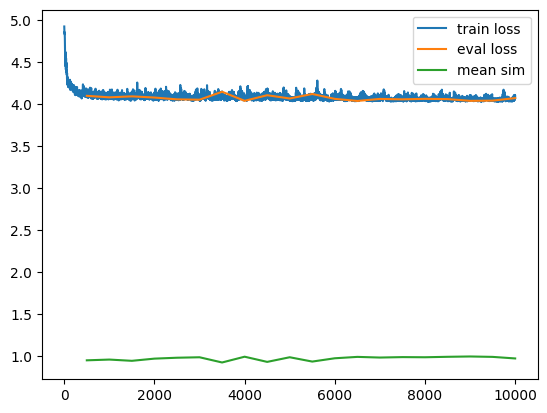

In [8]:
obs_dim = 77
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "Center", "North", "South", "East", "West",
                        "Gem", "Yellow", "Green", "Purple"]
max_mess_len = 6

ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

n_ep = 10000
eval_every = 500
batch_size=128

train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

plot_curves(train_losses, eval_losses, eval_sims, eval_every)

In [29]:
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/PPrgb_15_langground.pt")

PP_12

  0%|          | 0/10000 [00:00<?, ?it/s]/home/maxtoq/Desktop/Dev/MADRL-PhD-Thesis-Code/venv/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 10000/10000 [04:11<00:00, 39.80it/s]


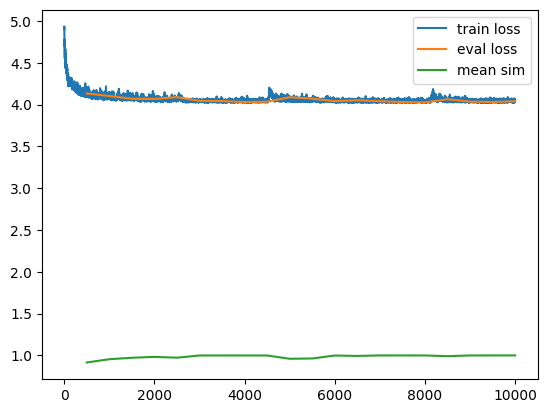

In [15]:
obs_dim = 77
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "Center", "North", "South", "East", "West",
                        "Gem", "Yellow", "Green", "Purple"]
max_mess_len = 6

# Make model
ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/PPrgb_12.csv", ll)

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/PPrgb_12_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

PP_18

Prepare data...
Training...


100%|██████████| 10000/10000 [03:48<00:00, 43.86it/s]


Saving model...
Plot...


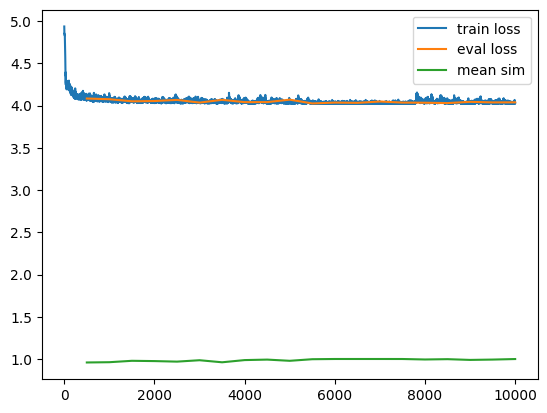

In [16]:
obs_dim = 77
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "Center", "North", "South", "East", "West",
                        "Gem", "Yellow", "Green", "Purple"]
max_mess_len = 6

# Make model
ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/PPrgb_18.csv", ll)
df.head()

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/PPrgb_18_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

F_18

Prepare data...
Training...


100%|██████████| 10000/10000 [07:12<00:00, 23.10it/s]


Saving model...
Plot...


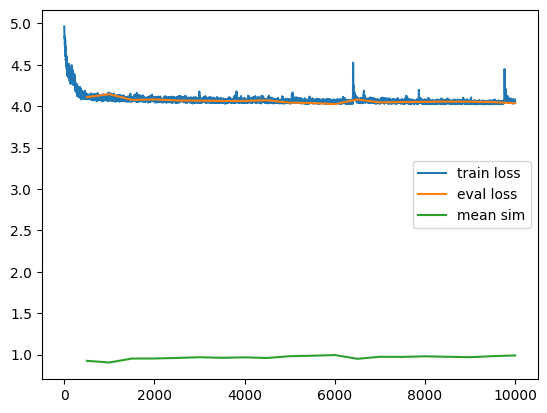

In [17]:
obs_dim = 77
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "Center", "North", "South", "East", "West",
                        "Gem", "Yellow", "Green", "Purple"]
max_mess_len = 6

# Make model
ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/Frgb_18.csv", ll)
print(df.head())

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/Frgb_18_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

#### Coordinated Placement

Prepare data...
                                obs lang
130  [0.6, 0.4, 0.0, 0.0, 0.0, 0.0]  [1]
138  [0.6, 0.6, 0.0, 0.0, 0.0, 0.0]  [1]
211  [0.4, 0.6, 0.0, 0.0, 0.0, 0.0]  [1]
359  [0.4, 0.4, 0.0, 0.0, 0.0, 0.0]  [1]
406  [0.6, 0.4, 0.0, 0.0, 0.0, 0.0]  [1]
Training...


100%|██████████| 10000/10000 [04:02<00:00, 41.15it/s]


Saving model...
Plot...


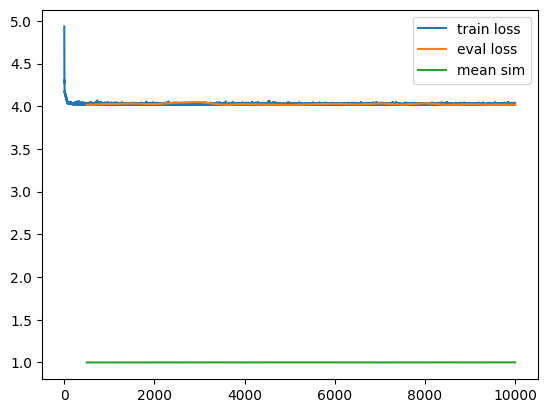

In [5]:
obs_dim = 6
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Red", "Green", "Blue", "Yellow", "Cyan", "Purple", 
         "Center", "North", "South", "East", "West"]
max_mess_len = 6

ll = LanguageEncoder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/CPrgb.csv", ll)
print(df.head())

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/CPrgb2a_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

#### MPE PredPrey shape

Prepare data...
                                                  obs          lang
14  [-0.7705280704034461, 0.5719982970523401, 0.0,...  [2, 3, 6, 1]
23  [-0.5857065058528779, -0.6382443555183748, 0.0...     [2, 4, 1]
32  [0.31305547473910234, 0.8914207302045101, 0.0,...     [2, 3, 1]
35  [0.21828665717393858, 0.8070788942479041, 1.0,...     [2, 3, 1]
38  [-0.798141632667738, -0.42427118839417, 0.0, 1...  [2, 4, 6, 1]
Training...


100%|██████████| 10000/10000 [11:22<00:00, 14.66it/s]


Saving model...
Plot...


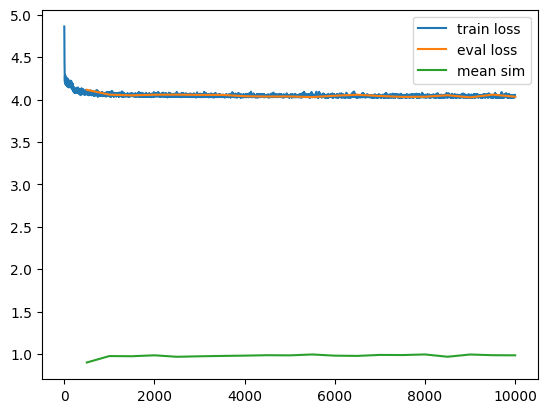

In [ ]:
from src.algo.policy_diff.langground import LanguageGrounder

import torch
import numpy as np
from torch import nn

obs_dim = 14
context_dim = 4
hidden_dim = 64
embed_dim = 4
n_layer = 2
lr = 0.007
vocab = ["Prey", "North", "South", "East", "West", "Center"]
max_mess_len = 3

ll = LanguageGrounder(obs_dim, context_dim, hidden_dim, embed_dim, n_layer, lr, vocab, max_mess_len)

# Load and prepare data
print("Prepare data...")
df = load_n_prep_data("../../results/data/lamarl_data/MPEPPshap.csv", ll)
print(df.head())

n_ep = 10000
eval_every = 500
batch_size=128

# Training
print("Training...")
train_losses, eval_losses, eval_sims = train_lang_encoder(
    df, ll, n_ep, batch_size, eval_every=eval_every, device="cpu")

print("Saving model...")
torch.save(ll.get_save_dict(), "../../results/data/lamarl_data/MPEPPshap_langground.pt")

print("Plot...")
plot_curves(train_losses, eval_losses, eval_sims, eval_every)

## Display embedding clusters

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from matplotlib.cm import get_cmap
import seaborn as sns

ll.prep_rollout("cpu")

eval_data = df.iloc[-10000:]

# Remove rows with long messages
rids = []
for i, row in eval_data.iterrows():
    if len(row["lang"]) > 4:
        rids.append(i)
display_data = eval_data.drop(rids)
display_data


,obs,lang
3928849,"[0.42857142857142855, 1.0, 0.0, 0.0, 0.0, 0.0,...","[2, 6, 1]"
3928856,"[0.6428571428571429, 0.42857142857142855, 0.0,...","[2, 3, 1]"
3928870,"[0.7857142857142857, 0.21428571428571427, 0.0,...","[2, 3, 1]"
3928875,"[0.14285714285714285, 0.9285714285714286, 0.0,...","[2, 4, 6, 1]"
3928881,"[0.7857142857142857, 0.5714285714285714, 0.0, ...","[2, 3, 1]"
...,...,...
3999936,"[0.9285714285714286, 0.21428571428571427, 0.0,...","[2, 5, 7, 1]"
3999946,"[0.21428571428571427, 0.7857142857142857, 0.0,...","[2, 3, 1]"
3999948,"[0.42857142857142855, 0.6428571428571429, 0.0,...","[2, 3, 1]"
3999975,"[0.07142857142857142, 0.42857142857142855, 0.0...","[2, 4, 1]"


In [31]:
len(list(eval_data.obs)[0])

77

In [21]:
obs = torch.Tensor(np.array(list(eval_data["obs"])))
lang = [' '.join(s) for s in ll.word_encoder.decode_batch(list(eval_data["lang"]))]

enc_obs = ll.obs_encoder(obs).detach().numpy()

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(enc_obs)



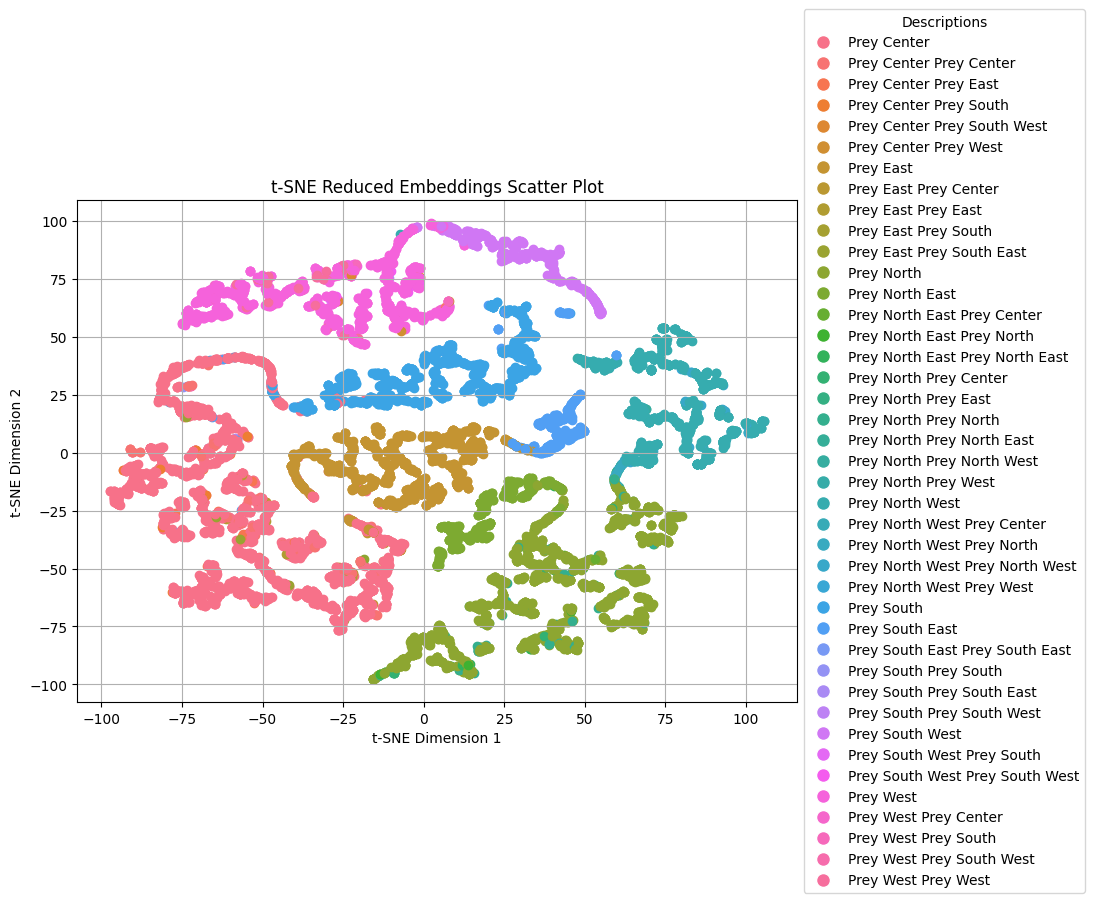

In [28]:
# Map descriptions to unique numeric labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(lang)

# Generate a color map
unique_labels = np.unique(labels)
# cmap = get_cmap('glasbey_bw', len(unique_labels))  # Use a larger colormap
clrs = sns.color_palette('husl', n_colors=len(unique_labels))
label_to_color = {label: clrs[idx] for idx, label in enumerate(unique_labels)}

# Scatter plot
plt.figure(figsize=(13, 8))
for idx, embedding in enumerate(embeddings_2d):
    label = labels[idx]
    plt.scatter(embedding[0], embedding[1], color=label_to_color[label], label=lang[idx])

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label], markersize=10) 
           for label in unique_labels]
labels = label_encoder.inverse_transform(unique_labels)
plt.legend(handles, labels, title="Descriptions", loc="center left", bbox_to_anchor=(1, 0.5))

# Plot settings
plt.title("t-SNE Reduced Embeddings Scatter Plot")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)

# Show plot
plt.tight_layout(rect=[0, 0, 0.85, 1])

In [26]:
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40])